In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import scib

In [3]:
import sys
sys.path.append("../../../autotalker")

In [4]:
from autotalker.benchmarking import compute_clisis, compute_cas

In [76]:
adata_auto = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_autotalker_oneshot_integrated.h5ad")
model = "autotalker"
adata = adata_auto

In [77]:
# Gene Program Mask
nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9

# Data
dataset = "starmap_plus_mouse_cns"
reference_batches = ["batch1_sample", "batch2_sample", "batch3_sample"]
counts_key = "counts"
condition_key = "batch"
n_neighbors = 12
spatial_key = "spatial"
adj_key = "spatial_connectivities"
mapping_entity_key = "mapping_entity"
filter_genes = True
n_hvg = 2000
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
gp_names_key = "autotalker_gp_names"

# Model
load_timestamp = "27032023_184359"
latent_key = "latent"

# Benchmarking
cell_type_key = "cell_type"
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

# Other
random_seed = 0

In [78]:
# Compute metrics
metrics_dict = {}

# Spatial conservation metrics
metrics_dict["cas"] = compute_cas(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")
metrics_dict["clisis"] = compute_clisis(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")

# Batch correction metrics
metrics_dict["asw"] = scib.me.silhouette_batch(
    adata=adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=f"{model.lower()}_{latent_key}_run1")
metrics_dict["ilisi"] = scib.me.ilisi_graph(
    adata=adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=f"{model.lower()}_{latent_key}_run1")
    #type_="knn")

Computing spatial nearest neighbor graph for batch embryo1_z2...
Computing spatial nearest neighbor graph for batch embryo1_z5...
Computing spatial nearest neighbor graph for batch embryo2_z2...
Computing spatial nearest neighbor graph for batch embryo2_z5...
Computing spatial nearest neighbor graph for batch embryo3_z2...
Computing spatial nearest neighbor graph for batch embryo3_z5...
Combining spatial nearest neighbor graphs...
Computing spatial neighborhood enrichment scores...
Computing latent nearest neighbor graph...
Computing latent neighborhood enrichment scores...
Computing CAS...
Using precomputed spatial nearest neighbor graph...
Computing spatial cell CLISI scores for entire dataset...
Using precomputed latent nearest neighbor graph...
Computing latent cell CLISI scores...
Computing CLISIS...
mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.927927
Anterior 

In [79]:
# Autotalker
metrics_dict

{'cas': 0.5662278494207724,
 'clisis': 0.9163041173662493,
 'asw': 0.9223261307054829,
 'ilisi': 0.10303709148621976}

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages

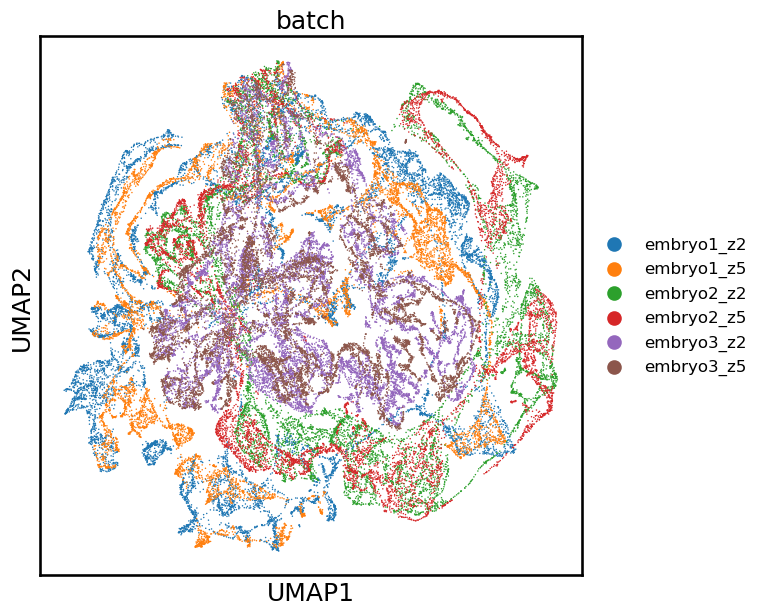

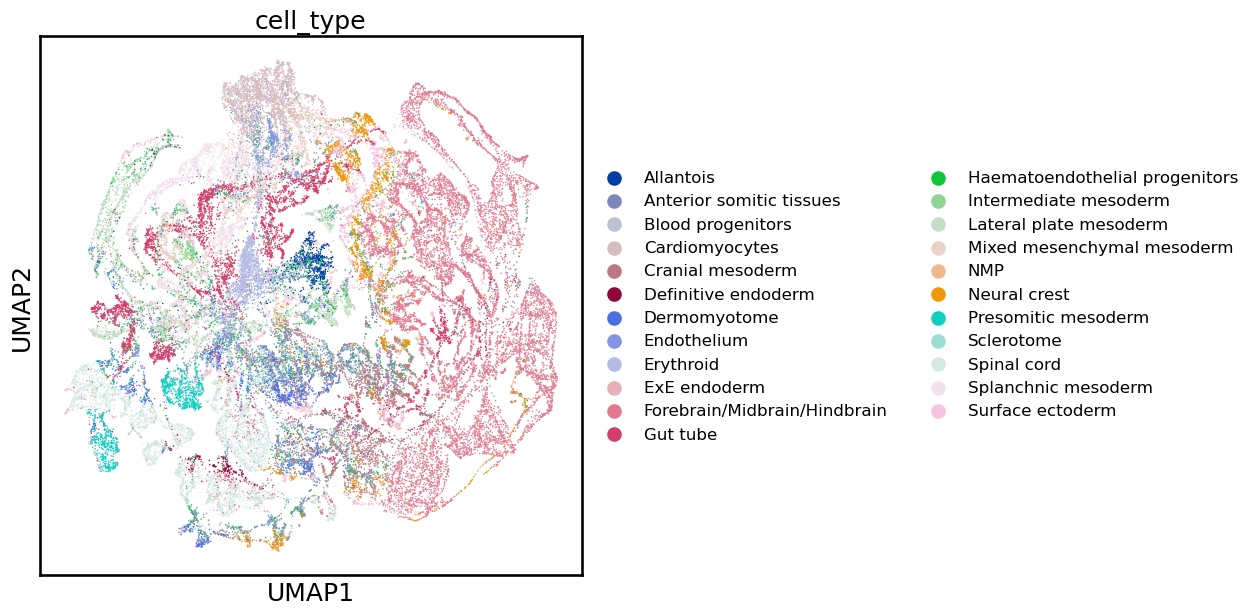

In [80]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [69]:
# Autotalker
metrics_dict

{'cas': 0.5761004458116412,
 'clisis': 0.9101863265663724,
 'asw': 0.8626960288428984,
 'ilisi': 0.33048612449357273}

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages

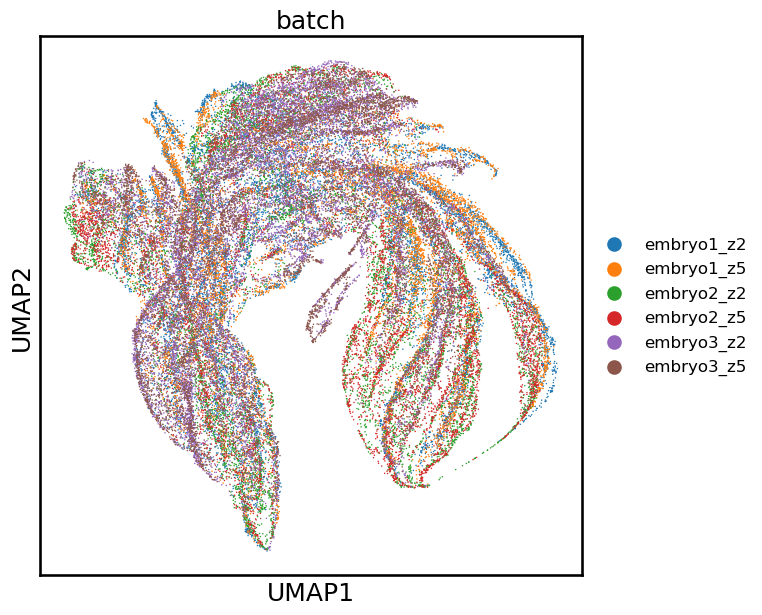

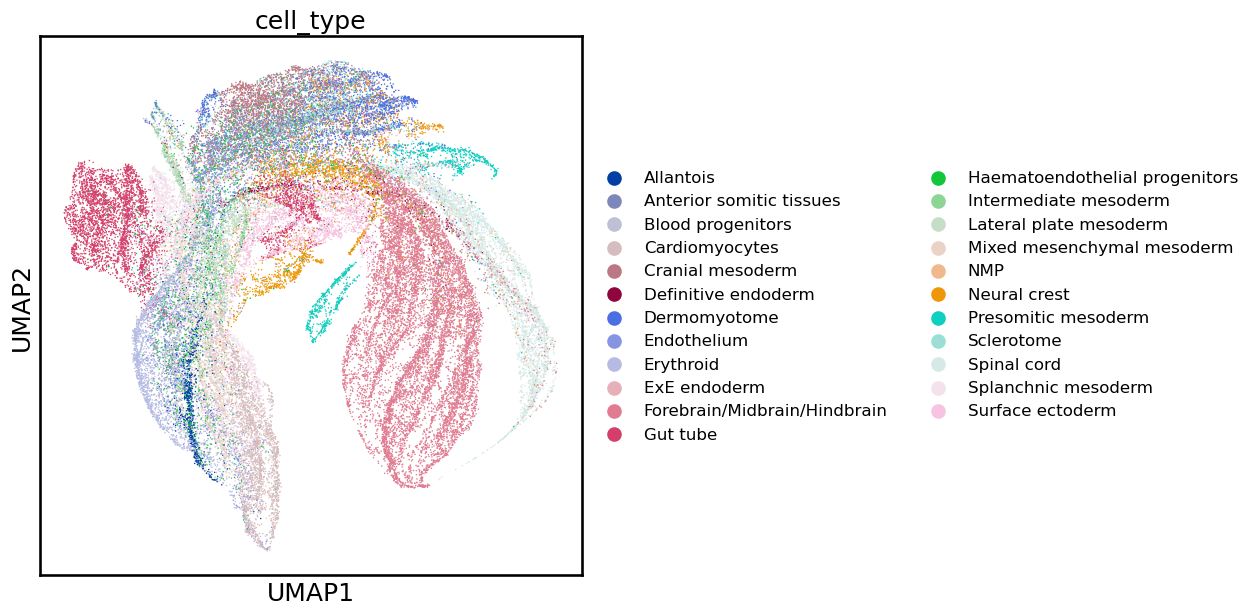

In [70]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
# Autotalker new (2 layers)
metrics_dict

In [ ]:
# Autotalker new
metrics_dict

In [ ]:
# Autotalker old
metrics_dict

In [ ]:
adata_graph = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_graphst_oneshot_integrated.h5ad")
model = "graphst"
adata = adata_graph

In [ ]:
# GraphST
metrics_dict

In [ ]:
# GraphST
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annbbbbotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
adata_scvi = sc.read_h5ad("../../datasets/srt_data/gold/results/seqfish_mouse_organogenesis_scvi_oneshot_integrated.h5ad")
model = "scvi"
adata = adata_scvi

In [ ]:
# scVI
metrics_dict

In [ ]:
# scVI
sc.pp.neighbors(adata,
                use_rep=f"{model}_{latent_key}_run1")
sc.tl.umap(adata)

# Plot UMAP with batch annotations
fig = sc.pl.umap(adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)


# Plot UMAP with cell type annbbbbotations
fig = sc.pl.umap(adata,
                 color=[cell_type_key],
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(7)
fig.set_figwidth(7)

In [ ]:
adata.obsp["autotalker_latent_run1_connectivities"].sum(axis=1)

In [ ]:
sc.pp.neighbors(adata=adata,
                # use_rep=spatial_key,
                n_neighbors=15,
                random_state=0,
                key_added="spatial",
                knn=True)

In [ ]:
adata.obsp["spatial_connectivities"].toarray()[:10, :200]

In [ ]:
batches = adata.obs[condition_key].unique().tolist()[:7]

In [ ]:
adata_batch_list = []
for batch in batches:
    adata_batch_list.append(adata[adata.obs[condition_key] == batch][:50, :].copy())
adata = sc.concat(adata_batch_list, join="inner")

adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [ ]:
adata

In [ ]:
adata_sample = adata[:5, :]

In [ ]:
adata_sample = adata_batch_list[0].copy()

In [ ]:
adata_sample.obsp["spatial_connectivities"].toarray()

In [ ]:
import squidpy as sq
sq.gr.nhood_enrichment(adata=adata_sample,
                       cluster_key="cell_type",
                       connectivity_key="spatial",
                       n_perms=1000,
                       seed=0,
                       show_progress_bar=False)

In [ ]:
# Compute metrics
metrics_dict = {}

# Spatial conservation metrics
metrics_dict["cas"] = compute_cas(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")
"""
metrics_dict["clisis"] = compute_clisis(
    adata=adata,
    cell_type_key=cell_type_key,
    condition_key=condition_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=f"{model.lower()}_{latent_key}_run1")

# Batch correction metrics
metrics_dict["asw"] = scib.me.silhouette_batch(
    adata=adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=f"{model.lower()}_{latent_key}_run1")
metrics_dict["ilisi"] = scib.me.ilisi_graph(
    adata=adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=f"{model.lower()}_{latent_key}_run1")
    #type_="knn")
"""